# Introduction to Multiple Linear Regression

在简单线性回归的代码部分，我们分析了120个二手车价格(price)和车龄(ageOfCar)之间的关系，得到了可以通过车龄来预测价格的线性模型。但是，实际的二手车市场中，影响二手车价格的因素远远不止车龄。与价格相关的还有因素诸如：行驶里程，车辆是否损坏等等。

所以如果我们能够将更多的信息加入之前的模型，那么模型的预测能力应该可以进一步提升。所以在本章中，我们会利用上一节介绍的多元线性回归（Multiple Linear Regression）方法，在之前的二手车数据中加入行驶里程（kilometer）和是否车辆有损坏（isDamaged）这两个predictor，来建立一个更准确的二手车价格预测方法。

在本章的教程中，你会学到：
* 如何对predictor进行筛选
* 如何建立哑变量（dummy variable）
* 如何使用箱线图（boxplot）
* 如何建立多元线性模型
* 如何比较不同的多元线性模型的结果

## 1.准备工作

首先我们来引入Python库。

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# this allows plots to appear directly in the notebook
%matplotlib inline

## 2.数据探索

接着，我们来读取新的二手车数据，看一看数据中包含的值。

**(1) 读入数据**

In [4]:
auto_df = pd.read_csv('./data/auto_multiple.csv', index_col=0)

**(2) 显示数据**

用`head()`打印出数据表格（dataframe）的前5行。

In [5]:
auto_df.head()

,name,price,kilometer,vehicleType,ageOfCar,isDamaged
0,Volkswagen_Golf_1.4,1599,150000,limousine,18,no
1,Volkswagen_Golf_1.4,10300,50000,limousine,5,no
2,Volkswagen_Golf_1.4,1600,150000,limousine,14,no
3,Volkswagen_Golf_1.4,7300,70000,limousine,7,no
4,Volkswagen_Golf_1.4,599,125000,limousine,18,no


**(3) 数据字典**
- ageOfCar: 车辆的使用年数。
- name: 车的型号。
- kilometer: 行驶公里数。
- vehicleType: 车辆类别。
- isDamaged: 有没有事故记录。
- price: 二手车的出售价格。

以上六个feature中，price是outcome，其它5项的是predictor。

**(4) 数据量**

用pandas的`shape()`函数查看数据表格（dataframe）的行数和列数，我们看到这个数据表中有160个observation。

In [6]:
auto_df.shape

(160, 6)

**(5) 数据质量检测**

首先我们来进一步的看看每一项数据的内容，第一件事情我们要了解的是数据库中有没有空值。如果有空值，会在训练模型的部分引发错误，所以我们需要这一步处理空值。

Pandas数据表有一个自带函数`isna()`，用于检测每一个feature的每一个值是否为空，然后返回一个同样尺寸的数据表（dataframe）。如果某个数据为空，则新的数据表对应位置的值为True，反之则为False。

In [9]:
auto_check_null = auto_df.isna()
auto_check_null.head()

,name,price,kilometer,vehicleType,ageOfCar,isDamaged
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


我们可以用`sum()`函数将这些True/False值相加，True会自动变为1，False会自动转为0。加完后的数字，就代表每一个feature中间空值的数量。

In [10]:
auto_check_null.sum()

name           0
price          0
kilometer      0
vehicleType    0
ageOfCar       0
isDamaged      0
dtype: int64

我们可以看到，没有空值，所以我们可以继续下面的分析。

## 3.数据可视化

接下来，我们对数据进行可视化，用图表将每个predictor与outcome的关系体现出来，看看能否发现出一些规律。

5个predictor包含连续变量（continuous variable）和分类变量（categorical variable）。其中：
* **连续变量:** 行驶公里数（kilometer）, 车龄（ageOfCar）
* **分类变量:** 车辆类别（vehicleType）, 车辆损坏状态（isDamaged）, 车辆名称（name）

对于连续变量，我们可以通过绘制散点图，来观察它们与价格（price）之间是否存在相关性。

而对于分类变量，我们主要观察两点：
1. 包含哪些类别，对应observation的数量是多少。
2. 每个类别中价格的分布情况。


我们先来看连续变量：

**(1) 公里数（kilometer）**

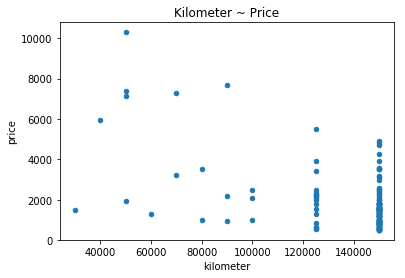

In [16]:
auto_df.plot(kind='scatter', x='kilometer', y='price', title='Kilometer ~ Price')

行驶公里数（kilometer）和价格（price）之间，呈现出来一个微弱的线性关系。并且从散点图中我们能看到，kilometer的值非常的分散，都是以“万”为单位的数值，颗粒度非常大，这可能对模型的帮助会比较有限。我们在后续建模的时候，会进一步评估行驶公里数作为predictor对结果的贡献。

**(2) 车龄（ageOfCar）**

再来看看车龄（ageOfCar）和价格（price）之间的关系：

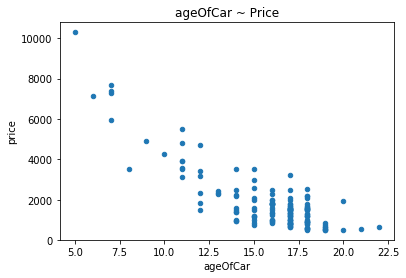

In [18]:
auto_df.plot(kind='scatter', x='ageOfCar', y='price', title='ageOfCar ~ Price')

从上图中我们看出，车龄（ageOfCar）和价格（price）之间有一个明确的近似线性关系，随着车龄的增加，价格按照一个大致的比例降低。

接下来，我们来观察分类变量。

**(3) 型号（name）**

对于categorical variable，第一件事情是要知道有哪几个值。Numpy有一个去除重复值的方法，叫做`unique()`。传入一个Series，`unique()`就会给出Series中有哪些值。

In [25]:
np.unique(auto_df['name'])

array(['Volkswagen_Golf_1.4'], dtype=object)

我们发现，汽车型号（name）这个feature中只有1个值，也就是说，所有的车都是大众的高尔夫（Volkswagen Golf）。如果feature只有唯一值，那么它对预测就起不到作用，所以我们建模的时候不会使用型号（name）。

**(4) 车辆类别（vehicleType）**

In [26]:
np.unique(auto_df['vehicleType'])

array(['coupe', 'kleinwagen', 'limousine'], dtype=object)

有趣的事情发生了。同样是大众高尔夫，车辆类别却出现了三类：双门轿车（coupe），小轿车（kleinwagen），豪车（limousine）。由于这些车辆类别是由卖家自己选择的，所以这能够反映出车辆在卖家心里的地位。我们来看一看三种类别的数量占比：

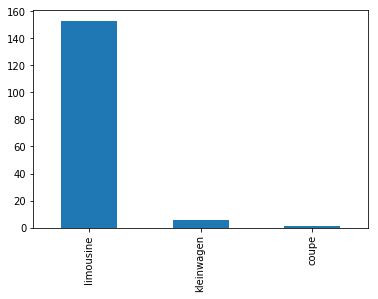

In [29]:
auto_df['vehicleType'].value_counts().plot(kind='bar')

我们看到，绝大部分的observation中，车辆类别（vehicleType）都是豪华车。所以其能给模型带来的信息量也不多，我们决定不将其纳入建模的范畴。

**(5) 事故记录（isDamaged）**

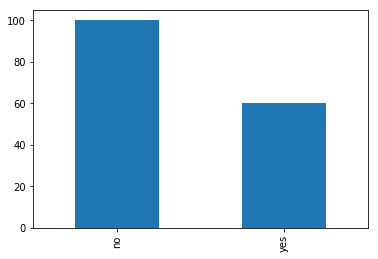

In [30]:
auto_df['isDamaged'].value_counts().plot(kind='bar')

我们可以看到，事故记录（isDamaged）是分布比较均衡的一个predictor，而且由于只有两个值（yes / no），我们可以将它转换为dummy variable，保存为新的变量名`isDamagedDummy`。

首先，我们在auto_df数据表中建立名为isDamagedDummyd的feature，全部赋值为0。

In [6]:
auto_df['isDamagedDummy'] = 0

接着，我们利用数据表自带的定位函数`loc()`，传入两个定位参数：`auto_df['isDamaged'] == 'yes'`筛选出所有'isDamaged'值为'yes'的行，`isDamagedDummy`是新的变量名。接着，将`loc()` 函数定位的值修改为1。

In [7]:
auto_df.loc[auto_df['isDamaged'] == 'yes', 'isDamagedDummy'] = 1

In [37]:
auto_df.head().T

,0,1,2,3,4
name,Volkswagen_Golf_1.4,Volkswagen_Golf_1.4,Volkswagen_Golf_1.4,Volkswagen_Golf_1.4,Volkswagen_Golf_1.4
price,1599,10300,1600,7300,599
kilometer,150000,50000,150000,70000,125000
vehicleType,limousine,limousine,limousine,limousine,limousine
ageOfCar,18,5,14,7,18
isDamaged,no,no,no,no,no
isDamagedDummy,0,0,0,0,0


这样我们的dummy variable就创建好了，我们会用`isDamagedDummy`替代`isDamaged`来建模。

接下来，我们观察一下，基于车辆损坏情况的价格分布。

不同于车龄和价格，车辆损坏状态是一个非0即1的哑变量（dummy variable）。散点图主要用于体现连续变量（continuous variable）之间的关系，所以不再适用于价格（price）与车辆损坏状态（isDamaged）之间的关系表达。

此处我们引入一种新的图表类型，叫做箱线图（boxplot），可以用于体现连续变量基于不同哑变量的分布规律。对于箱线图（boxplot）的解释见下图：

![Boxplot Explanation](img/boxplot.png)

接下来，我们就用pandas自带的boxplot()函数，来可视化车辆损坏状态（isDamaged）和价格（price）之间的关系：

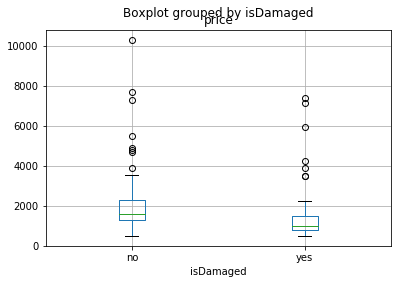

In [5]:
auto_df.boxplot(column=['price'], by='isDamaged')

可以看到，对于有损坏的车辆，价格要低于没有损坏的车辆。然后有一些价格非常高的值，这可能是个别车况非常好的二手车，或者是个别卖家定价远高于市场水平的情况。（备注：所有数据都对应同一款车型）

## 4.建立模型（Multiple Linear Model）

**(1) 数据预处理**

和simple linear regression类似，我们会得到包含3个predictor的线性模型，它的公式是：

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3$

这里的$x_1, x_2, x_3$就是我们的三个predictor: 车龄（ageOfCar），公里数（kilometer）和事故记录（isDamagedDummy）。

接下来，我们用Statsmodels来建立Multiple Linear Regression的模型。

我们将'ageOfCar', 'isDamagedDummy', 'kilometer'三个predictor赋值给X，并且加入常数1。

然后将'price'赋值给Y，作为outcome。

In [8]:
X = auto_df[['ageOfCar', 'isDamagedDummy', 'kilometer']]
X = sm.add_constant(X)
Y = auto_df['price']

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


我们把X和Y用`head()`函数打印出前5行，验证格式正确。

In [9]:
X.head()

,const,ageOfCar,isDamagedDummy,kilometer
0,1.0,18,0,150000
1,1.0,5,0,50000
2,1.0,14,0,150000
3,1.0,7,0,70000
4,1.0,18,0,125000


In [45]:
Y.head()

0     1599
1    10300
2     1600
3     7300
4      599
Name: price, dtype: int64

**(2) 训练模型**

接下来我们来训练模型，找到最佳系数$\beta_0, \beta_1, \beta_2, \beta_3$。

In [10]:
model1 = sm.OLS(Y, X).fit()

## 5.评估模型

接下来我们看看模型的效果如何，使用`summary()`方法给出模型的参数。

In [11]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     194.5
Date:                Fri, 02 Aug 2019   Prob (F-statistic):           1.70e-52
Time:                        23:48:46   Log-Likelihood:                -1273.2
No. Observations:                 160   AIC:                             2554.
Df Residuals:                     156   BIC:                             2567.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.009e+04    364.504     27.685      0.000    9371.344    1.08e+04
ageOfCar        -380.9576     20.540    -18.547      0.000    -421.530    -340.385
isDamagedDummy  -618.4489    114.427     -5.405      0.000    -844.475    -392.423
kilometer         -0.0143      0.002     -6.076      0.000      -0.019      -0.010
==============================================================================
Omnibus:                       11.845   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.522
Skew:                           0.159   Prob(JB):                     6.41e-07
Kurtosis:                       5.044   Cond. No.                     9.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

比起之前仅用车龄（ageOfCar）作为predictor的simple linear regression，这个模型的R值（R-squared）值从0.692提升到0.789。说明加入新的数据（公里数，损坏记录）后，我们有了更好的模型。

带入系数，模型可以写作：$price = 10090 - 380*ageOfCar -618 * isDamagedDummy - 0.0143*kilometer$

这个公式表示，在其他条件相同的情况下：
* 车龄每增加1年，价格预期会下跌380美元；
* 有损坏记录的车，价格会比没有损坏记录的车平均便宜618元；
* 每多开1km，价格预期下降0.0143美元；


## 6.Predictor的选择

虽然以上模型中，三个predictor的P值都约等于0，意味着它们都对于预测结果有显著意义。但由于我们之前对于kilometer和price的线性关系有疑问，不妨试一试如果剔除kilometer，我们的模型效果会提升还是下降。

In [12]:
X = auto_df[['ageOfCar', 'isDamagedDummy']]
X = sm.add_constant(X)
Y = auto_df['price']
model2 = sm.OLS(Y, X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     222.5
Date:                Fri, 02 Aug 2019   Prob (F-statistic):           1.53e-46
Time:                        23:48:51   Log-Likelihood:                -1290.2
No. Observations:                 160   AIC:                             2586.
Df Residuals:                     157   BIC:                             2596.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8896.8688    340.241     26.149      0.000    8224.829    9568.908
ageOfCar        -431.1245     20.848    -20.680      0.000    -472.303    -389.946
isDamagedDummy  -594.2428    126.764     -4.688      0.000    -844.627    -343.859
==============================================================================
Omnibus:                       26.621   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.364
Skew:                           0.754   Prob(JB):                     2.58e-12
Kurtosis:                       5.393   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

结果是，剔除公里数（kilometer）后，R值下降了5%。这说明公里数对于价格是一个有意义的predictor。

R值下面有一个Adj. R-squared，翻译成**修正后的R值**，通常小于R值。下面我们来解释一下其含义：

首先，加入更多的predictor不会让结果变得更糟，因为模型可以通过将系数设为0来排除新的predictor对结果的影响。

但是新加入predictor会让模型变得更复杂，从而更容易使得模型过拟合。我们希望越简单的模型越好，即predictor越少越好。修正后的R值（Adj. R-squared）实际上就是在R值的基础上，根据predictor的数量加入了一定的“惩罚”。Predictor的数量越多，惩罚越大。想更深入了解的同学可以参考这一篇文章：[under-penalizes complexity](http://scott.fortmann-roe.com/docs/MeasuringError.html).

用于比较当两个模型表现的时候，使用修正后的R值进行比较会给我们更全面的评估结果。在我们的模型中，移除公里数后，修正后的R值也下降了约5%。所以这进一步说明公里数对于价格是一个有意义的predictor。

## 7.模型的应用

**(1) 预测**

根据上述分析，model1是更好的模型。我们来利用其`predict()`函数对一个车龄10年，没有损坏记录，行驶了11.9万公里的车进行价格预测：

In [13]:
# 建立用于预测的数据，数组中四个值分别代表：截距常量，ageOfCar，isDamagedDummy，kilometer
new_X = [1, 10, 0, 119000]
# 使用model1的predictor函数对新的车辆进行预测
new_predictions = model1.predict(new_X)
#结果以数组形式输出，此处的[0]是将数组中的数字取出。
new_predictions[0] 

4585.8560290237365

所以，我们预计一个车龄10年，没有损坏记录，行驶了11.9万公里的车价格约为4586美元。

**(2) 模型的应用范围**

基于训练数据的分布，我们的价格预测模型可以应用于车龄6-20年，行驶里程数为30000至150000公里之间的二手车。

## Summary & Next

本章我们利用多元线性回归（Multiple Linear Regression）建立了一个更准确的二手车价格预测模型，同时涵盖了以下的知识要点：

* 如何对predictor进行筛选
* 如何建立哑变量（dummy variable）
* 如何使用箱线图（boxplot）
* 如何建立多元线性模型
* 如何比较不同的多元线性模型的结果

至此，我们完成了线性回归部分的学习。利用这几章的知识，同学们也已经具备解决一些实际问题的能力了。接下来，我们会继续一起探索扩展能力的边界。

下一章中，我们会介绍逻辑回归（Logistic Regression），这个分析方法常用于解决医疗领域的诊断（分类）问题。